In [114]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [115]:
import os
os.environ["KERAS_BACKEND"] = "jax"

In [116]:
import keras
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

np.set_printoptions(suppress=True)

In [117]:
import bayesflow as bf

In [118]:
from ddm_priors import (
    ddm_baseline_priors,
    ddm_standard_priors,
    ddm_advanced_priors
)

from ddm_simulator import simulate_ddm_trial, simulate_ddm

In [119]:
baseline_simulator = bf.make_simulator([ddm_baseline_priors, simulate_ddm])
standard_simulator = bf.make_simulator([ddm_standard_priors, simulate_ddm])
advanced_simulator = bf.make_simulator([ddm_advanced_priors, simulate_ddm])

In [120]:
simulator = bf.simulators.ModelComparisonSimulator(
    simulators=[baseline_simulator, standard_simulator, advanced_simulator]
)

In [121]:
sim_data = simulator.sample(100)

for k, v in sim_data.items():
    print(k, v.shape)

v (100, 1)
a (100, 1)
z (100, 1)
tau (100, 1)
rts (100, 500, 1)
choices (100, 500, 1)
model_indices (100, 3)


In [122]:
sim_data["model_indices"]

array([[1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0,

In [123]:
adapter = (
    bf.Adapter()
    .convert_dtype("float64", "float32")
    .concatenate(["rts", "choices"], into="summary_variables")
    .concatenate(["v", "a", "z", "tau"], into="inference_variables")
)

In [124]:
adapted_sims = adapter(sim_data)
for k, v in adapted_sims.items():
    print(k, v.shape)

model_indices (100, 3)
summary_variables (100, 500, 2)
inference_variables (100, 4)


In [125]:
summary_network = bf.networks.DeepSet()
classifier_network = bf.networks.MLP(widths=[32] * 5, activation="silu", dropout=None)

In [126]:
approximator = bf.approximators.ModelComparisonApproximator(
    num_models=3,
    classifier_network=classifier_network,
    summary_network=summary_network,
    adapter=adapter,
    standardize="summary_variables"
)

In [127]:
num_batches_per_epoch = 256
batch_size = 128
epochs = 10

In [128]:
learning_rate = keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=1e-4, 
    decay_steps=epochs * num_batches_per_epoch
)
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
approximator.compile(optimizer=optimizer)

In [129]:
history = approximator.fit(
    epochs=epochs,
    num_batches=num_batches_per_epoch,
    batch_size=batch_size,
    simulator=simulator,
    adapter=adapter
)

INFO:bayesflow:Building dataset from simulator instance of ModelComparisonSimulator.
INFO:bayesflow:Using 20 data loading workers.
INFO:bayesflow:Building on a test batch.


Epoch 1/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 353s 1s/step - loss: 1.7159
Epoch 2/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 297s 1s/step - loss: 0.8708
Epoch 3/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 300s 1s/step - loss: 0.7817
Epoch 4/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 288s 1s/step - loss: 0.7544
Epoch 5/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 289s 1s/step - loss: 0.7366
Epoch 6/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 293s 1s/step - loss: 0.7248
Epoch 7/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 289s 1s/step - loss: 0.7188
Epoch 8/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 289s 1s/step - loss: 0.7113
Epoch 9/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 293s 1s/step - loss: 0.7100
Epoch 10/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 293s 1s/step - loss: 0.7059


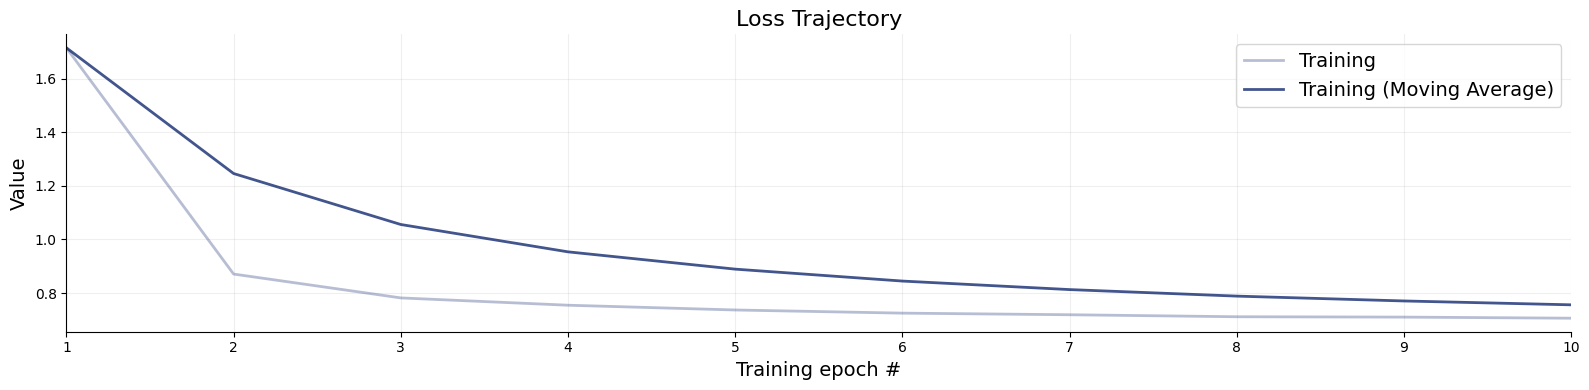

In [130]:
f = bf.diagnostics.plots.loss(history=history)

In [131]:
df = simulator.sample(500, n=10)

In [132]:
pred_models = approximator.predict(conditions=df, probs=True)

INFO:matplotlib.mathtext:Substituting symbol M from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol M from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol M from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol M from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol M from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol M from STIXNonUnicode


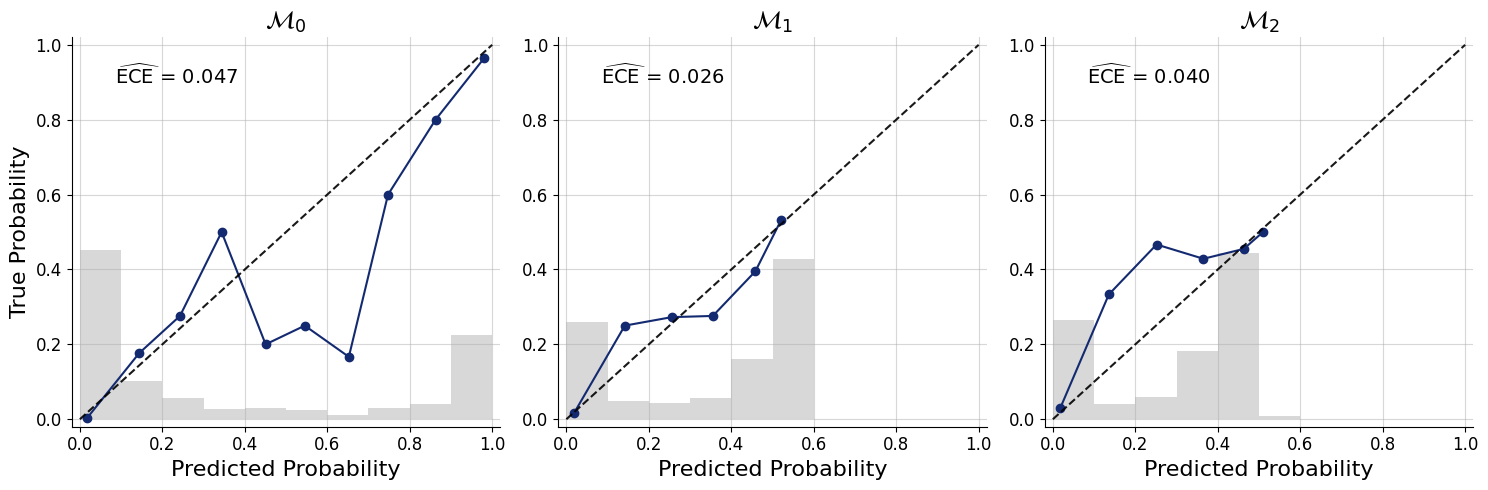

In [134]:
f = bf.diagnostics.plots.mc_calibration(
    pred_models=pred_models,
    true_models=df["model_indices"],
    model_names=[r"$\mathcal{M}_0$",r"$\mathcal{M}_1$", r"$\mathcal{M}_2$"],
)

INFO:matplotlib.mathtext:Substituting symbol M from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol M from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol M from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol M from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol M from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol M from STIXNonUnicode


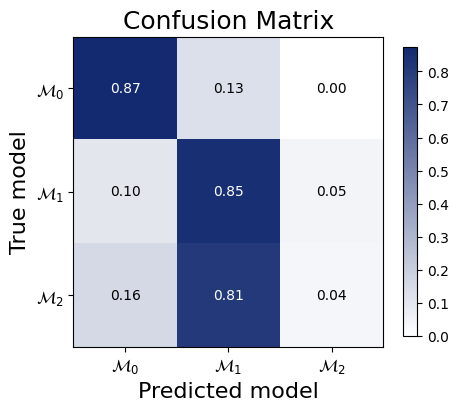

In [135]:
f = bf.diagnostics.plots.mc_confusion_matrix(
    pred_models=pred_models,
    true_models=df["model_indices"],
    model_names=[r"$\mathcal{M}_0$", r"$\mathcal{M}_1$", r"$\mathcal{M}_2$"],
    normalize="true",
)